# War card game analysis
Assumptions:
- if there are n players, then every player gets *(52 mod n)* cards and there are *(52 mod n) * n* cards in game
- non-playing cards are chosen from the lowest ones
- if there is a war and a player is out of cards (therefore can't continue the war), that player loses
- if a player has no cards in a hand but has in the side stack, then cards from the side stack will be shuffled and added to player's hand
- if a war occurs it is still counted as 1 move (no matter how long the war lasts)

e.g. if there are n = 3 players:
- num_of_cards_per_player = 52 mod 3 = 17
- num_of_cards_in_game = 17 * 3 = 51
- deck = [2, 3, 3, 3, 3, 4, ...]

Steps:
1. Defining deck of cards and card values
2. Defining variables for analysis: numer of rounds ...
3. N simulations:
    - shuffling cards and assigning them to n players (1 stack for hand and 1 stack for side cards)
    - N loops:
        1. move - comparison card values
        2. if war, then: 1st move without comparison, 2nd move with comparison (check condition again - recurency)
        3. add cards from the move to winner's side cards stack
        4. if one of the players has all cards, then stop
4. Analysis ...

In [10]:
# libraries
import pandas as pd
import numpy as np
import ipywidgets as widgets

## Simulations

In [13]:
# Defining deck of cards and card values
"""
Jack = 11
Queen = 12
King = 13
Ace = 14
"""
card_values = list(range(2, 15))
deck = list(4 * card_values)
deck.sort()

print(deck)

[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14]


In [15]:
def check_hands(players):
    for i, player in enumerate(players):
        # if hand is empty
        if not player['hand']:
            if player['side']:
                # shuffle side cards and move them to the hand
                np.random.shuffle(player['side'])
                player['hand'], player['side'] = player['side'], []
            else:
                # delete player who lost (has no cards at all)
                players.pop(i)

In [17]:
def make_move(players, cards_for_side, print_cards=True, ignore_values=False):
    """
    players: list of players with hands and sides
    cards_for_side: list of cards accumulated in the round that will be added to winner's side cards
    ignore_values: used in war for cards that are reversed and their values are not taken into account
    return: True if game over, else False

    Note: works only for 2 players for now!
    """
    
    check_hands(players)
    if len(players) <= 1:
        return True
        
    # rozgrywka dla na razie 2 graczy
    player_1_card = players[0]['hand'].pop(0)
    player_2_card = players[1]['hand'].pop(0)
    if print_cards:
        with output_widget:
            print(player_1_card, end="\t")
            print(player_2_card)
    cards_for_side += [player_1_card, player_2_card]

    if ignore_values:
        with output_widget:
            print("(above cards are reversed)")
        make_move(players, cards_for_side, print_cards, False)
    else:
        if player_1_card > player_2_card:
            players[0]['side'] += cards_for_side
        elif player_1_card < player_2_card:
            players[1]['side'] += cards_for_side
        else:
            
            if print_cards:
                with output_widget:
                    print("WAAAAR!!!!!")
            make_move(players, cards_for_side, print_cards, True)
    
            
    # return False

In [19]:
def make_move_more_players(players, cards_for_side, print_cards=True, ignore_values=False):
    """
    players: list of players with hands and sides (or list of players who take part in a war)
    cards_for_side: list of cards accumulated in the round that will be added to winner's side cards
    ignore_values: used in war for cards that are reversed and their values are not taken into account
    return: True if game over, else False
    """
    
    check_hands(players)
    if len(players) <= 1:
        return True

    # DEBUUGGING
    #if print_cards:
    #    for j, player in enumerate(players):
   #         print(f"{iter}: player{j+1}\nhand: {player['hand']}\nside: {player['side']}")
    #    print()
    
    # throw cards
    players_cards = []
    for player in players:
        if player['hand']:
            players_cards.append(player['hand'].pop(0))

    """
    if print_cards:
        with output_widget:
            for card in players_cards:
                print(card, end="\t")
            print()
    """
    cards_for_side += players_cards

    # war: thrown cards are reversed, now throw cards whose values count
    if ignore_values:
        """
        with output_widget:
            print("(above cards are reversed)")
        """
        make_move_more_players(players, cards_for_side, print_cards, False)
        
    # war: thrown cards' values count, now throw reversed cards
    # no war: choose the winner and add accumulated cards to his side
    else:
        max_card_value = max(players_cards)

        # war
        if players_cards.count(max_card_value) > 1:
            # find and save indexes of players who have a war
            players_with_highest_cards = [i for i, value in enumerate(players_cards) if value == max_card_value]
            players_on_war = [players[i] for i in players_with_highest_cards]

            """
            if print_cards:
                with output_widget:
                    print(players_with_highest_cards)
                    print("WAAAAR!!!!")
            """
            # war between specific players
            make_move_more_players(players_on_war, cards_for_side, print_cards, True)
            
        # no war
        else:
            winner_index = players_cards.index(max_card_value)
            players[winner_index]['side'] += cards_for_side
    
    return False

In [34]:
def war_card_game_simulation(N, players_number, start_seed=1):
    # variables for analysis
    rounds_in_each_simulation = []
    num_of_cards_in_game = 52 // players_number * players_number
    num_of_cards_per_player = num_of_cards_in_game // players_number
    
    # simulations
    for i in range(N):

        """
        if i == 0: # print only first simulation
            with output_widget:
                print(f"------------------------------------------------ {i+1}. SIMULATION ------------------------------------------------")
        """
        
        game_over = False
        iter = 0
        players = [ {'hand': [], 'side': []} for _ in range(players_number) ]
        
        # shuffling cards 
        shuffled_deck = deck.copy()
        shuffled_deck = deck[52-num_of_cards_in_game:]
        np.random.seed(start_seed + i)
        np.random.shuffle(shuffled_deck)

        # assign cards to players' hands
        for j, player in enumerate(players):
            player['hand'] = shuffled_deck[:num_of_cards_per_player]
            shuffled_deck = shuffled_deck[num_of_cards_per_player:]
            """ 
            if i == 0:
                with output_widget:
                    print(f"{iter}: player{j+1}\nhand: {player['hand']}\nside: {player['side']}")
        if i == 0:
            with output_widget:
                print()
                """     
        # game until someone wins

        print_cards = i == 0 # 28
        while not game_over:
            check_hands(players)
            game_over = make_move_more_players(players, [], print_cards)
            iter += 1
            
            """
            if i == 0:
                for j, player in enumerate(players):
                   
                    with output_widget:
                        print(f"{iter}: player{j+1}\nhand: {player['hand']}\nside:{player['side']}") 
                with output_widget:
                    print()
            """
        rounds_in_each_simulation.append(iter-1)
        
    return rounds_in_each_simulation

In [126]:
output_widget = widgets.Output(layout=widgets.Layout(width='100%', height='500px', overflow_y='auto')) # for printing simulation text

In [91]:
rounds_in_100_simulations = war_card_game_simulation(N = 10000, players_number = 6, start_seed=828) # 946 sie wywala

In [123]:
display(output_widget)

Output(layout=Layout(height='500px', overflow_y='auto', width='100%'), outputs=({'name': 'stdout', 'text': '--…

In [93]:
print(rounds_in_100_simulations[:20])

[474, 174, 94, 51, 296, 574, 161, 71, 136, 54, 447, 1034, 293, 84, 112, 253, 201, 130, 1304, 226]


In [95]:
len(rounds_in_100_simulations)

10000

## Analysis

In [47]:
import matplotlib.pyplot as plt

In [97]:
rounds_in_100_simulations = np.array(rounds_in_100_simulations)
rounds_in_100_simulations[:10]

array([474, 174,  94,  51, 296, 574, 161,  71, 136,  54])

In [99]:
df_rounds_in_100_simulations = pd.DataFrame(rounds_in_100_simulations)
df_rounds_in_100_simulations.describe()

,0
count,10000.000000
mean,312.370400
std,260.420801
min,12.000000
25%,133.000000
50%,235.000000
75%,407.000000
max,2313.000000


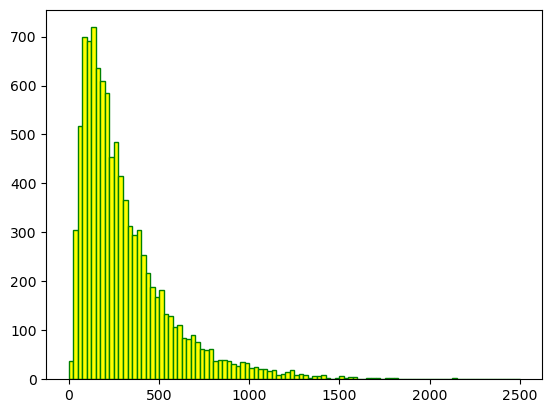

In [101]:
plt.hist(rounds_in_100_simulations, bins=100, range=(0, 2500), density=False, ec="green", color="yellow")
plt.show()

In [69]:
To-do:
- naprawic symulacje dla wiekszej liczby graczy (chyba cos w funkcji make_move_more_players)
 - jeśli dodam warunek:
    if(player['hand']):
            players_cards.append(player['hand'].pop(0))
    w make_move_more_players(), to wtedy nie ma problemu, ale jest potencjalny inny problem chyba: side nie jest shufflowany i dodawany do hand (w niektórych sytuacjach)
-  w przykładzie w 93 rundzie się coś dziwnego dzieje jeśli w war_card_game_simulation() nie ma check_hands() przed make_move
- w przykładzie jesli jest wiecej niz 6 graczy, to sie wysypuje

SyntaxError: invalid syntax (1942629332.py, line 1)